In [1]:
using Pkg
# cd("D:\\Home\\Git\\Oceananigans.jl")
cd("C:\\Users\\Ali\\Documents\\Git\\Oceananigans.jl\\")
Pkg.activate(".");

In [2]:
using Statistics, Printf
using Oceananigans, Oceananigans.Operators

In [3]:
# Pkg.test("Oceananigans")

In [4]:
@inline incmod1(a, n) = a == n ? one(a) : a + 1
@inline decmod1(a, n) = a == 1 ? n : a - 1

function laplacian3d_ppn(f)
    Nx, Ny, Nz = size(f)
    ∇²f = zeros(Nx, Ny, Nz)
    for k in 2:(Nz-1), j in 1:Ny, i in 1:Nx
       ∇²f[i, j, k] = f[incmod1(i, Nx), j, k] + f[decmod1(i, Nx), j, k] + f[i, incmod1(j, Ny), k] + f[i, decmod1(j, Ny), k] + f[i, j, k+1] + f[i, j, k-1] - 6*f[i, j, k]
    end
    for j in 1:Ny, i in 1:Nx
        ∇²f[i, j,   1] = -(f[i, j,     1] - f[i, j,   2]) + f[incmod1(i, Nx), j,   1] + f[decmod1(i, Nx), j,   1] + f[i, incmod1(j, Ny),   1] + f[i, decmod1(j, Ny),   1] - 4*f[i, j,   1]
        ∇²f[i, j, end] =  (f[i, j, end-1] - f[i, j, end]) + f[incmod1(i, Nx), j, end] + f[decmod1(i, Nx), j, end] + f[i, incmod1(j, Ny), end] + f[i, decmod1(j, Ny), end] - 4*f[i, j, end]
    end
    ∇²f
end

laplacian3d_ppn (generic function with 1 method)

In [5]:
Nx, Ny, Nz = 10, 1, 10
f = rand(Nx, Ny, Nz)
f .= f .- mean(f)
ϕ = solve_poisson_3d_ppn(f, Nx, Ny, Nz, 1, 1, 1)
laplacian3d_ppn(ϕ) ≈ f

true

In [6]:
# g =  RegularCartesianGrid((10, 1, 10), (2000, 2000, 1000), Float64)

In [26]:
include("src/operators/operators_old.jl")
include("src/equation_of_state_old.jl")

ρ (generic function with 1 method)

In [27]:
A3 = rand(10, 10, 10);
A2 = A3[:, 1:1, :];

In [28]:
slice = δˣf2c(A3)[:, 1:1, :]; @show slice == δˣf2c(A2);
slice = δˣc2f(A3)[:, 1:1, :]; @show slice == δˣc2f(A2);
slice = δʸf2c(A3)[:, 1:1, :]; @show slice == δʸf2c(A2);  # Should be zero. zeros(Nx, Ny, Nz)
slice = δʸc2f(A3)[:, 1:1, :]; @show slice == δʸc2f(A2);  # Should be zero. zeros(Nx, Ny, Nz)
slice = δᶻf2c(A3)[:, 1:1, :]; @show slice == δᶻf2c(A2);
slice = δᶻc2f(A3)[:, 1:1, :]; @show slice == δᶻc2f(A2);

slice == δˣf2c(A2) = true
slice == δˣc2f(A2) = true
slice == δʸf2c(A2) = false
slice == δʸc2f(A2) = false
slice == δᶻf2c(A2) = true
slice == δᶻc2f(A2) = true


In [29]:
slice = avgˣf2c(A3)[:, 1:1, :]; @show slice == avgˣf2c(A2);
slice = avgˣc2f(A3)[:, 1:1, :]; @show slice == avgˣc2f(A2);
slice = avgʸc2f(A3)[:, 1:1, :]; @show slice == avgʸc2f(A2);
slice = avgʸc2f(A3)[:, 1:1, :]; @show slice == avgʸc2f(A2);
slice = avgʸc2f(A3)[:, 1:1, :]; @show avgʸf2c(A2) == A2;
slice = avgʸc2f(A3)[:, 1:1, :]; @show avgʸc2f(A2) == A2;
slice = avgᶻf2c(A3)[:, 1:1, :]; @show slice == avgᶻf2c(A2);
slice = avgᶻc2f(A3)[:, 1:1, :]; @show slice == avgᶻc2f(A2);

slice == avgˣf2c(A2) = true
slice == avgˣc2f(A2) = true
slice == avgʸc2f(A2) = false
slice == avgʸc2f(A2) = false
avgʸf2c(A2) == A2 = true
avgʸc2f(A2) == A2 = true
slice == avgᶻf2c(A2) = true
slice == avgᶻc2f(A2) = true


In [30]:
const NumType = Float64  # Number data type.
const g = 9.80665  # Standard acceleration due to gravity [m/s²].
const χ = 0.1  # Adams-Bashforth (AB2) parameter.

Nˣ, Nʸ, Nᶻ = 100, 1, 100
Lˣ, Lʸ, Lᶻ = 2000, 2000, 2000  # Domain size [m].

Nᵗ = 50
Δt = 5  # Time step [s].

Δx, Δy, Δz = Lˣ/Nˣ, Lʸ/Nʸ, Lᶻ/Nᶻ  # Grid spacing [m].
Aˣ, Aʸ, Aᶻ = Δy*Δz, Δx*Δz, Δx*Δy  # Cell face areas [m²].
V = Δx*Δy*Δz  # Volume of a cell [m³].
M = ρ₀*V  # Mass of water in a cell [kg].

xC = Δx/2:Δx:Lˣ
yC = Δy/2:Δy:Lʸ
zC = -Δz/2:-Δz:-Lᶻ

uⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in x-direction [m/s].
vⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in y-direction [m/s].
wⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in z-direction [m/s].
Tⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Potential temperature [K].
Sⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Salinity [g/kg].
pʰʸ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ) # Hydrostatic pressure [Pa].
pⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Pressure [Pa].
ρⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Density [kg/m³].

Gᵘⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

Gᵘⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

Gᵘⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

pʰʸ′ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
pⁿʰ⁺ˢ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
g′ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
δρ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ);

In [31]:
uⁿ .= 0; vⁿ .= 0; wⁿ .= 0; Sⁿ .= 35;

# Tⁿ = repeat(reshape(T_ref, 1, 1, 50), Nˣ, Nʸ, 1)
Tⁿ .= 282.99

pHY_profile = [-ρ₀*g*h for h in zC]
pʰʸ = repeat(reshape(pHY_profile, 1, 1, Nᶻ), Nˣ, Nʸ, 1)
pⁿ = copy(pʰʸ)  # Initial pressure is just the hydrostatic pressure.

ρⁿ .= ρ.(Tⁿ, Sⁿ, pⁿ);

Tⁿ[Int(Nˣ/2)-2:Int(Nˣ/2)+2, 1, 10-2:10+2] .= 283.01;

In [32]:
# # PyPlot.pcolormesh( 0.2 * exp.(10*((xC .- Lˣ/2).^2 .+ (zC .+ Lᶻ/2)'.^2).^(-0.5)) ) ; PyPlot.colorbar();
# ΔT = 0.05 * exp.(10*((xC .- Lˣ/2).^2 .+ (zC .+ Lᶻ/2)'.^2).^(-0.5))
# ΔT = reshape(ΔT, (100, 1, 100))
# Tⁿ .= Tⁿ .+ ΔT;
# PyPlot.pcolormesh(Tⁿ[:, 1, :] .- 283) ; PyPlot.colorbar();

In [33]:
ΔR = 1
Ru = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# Rv = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
Rw = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
RT = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# RS = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
Rρ = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# RpHY′ = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
RpNHS = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ);

In [34]:
κʰ = 4e-2  # Horizontal Laplacian heat diffusion [m²/s]. diffKhT in MITgcm.
κᵛ = 4e-2  # Vertical Laplacian heat diffusion [m²/s]. diffKzT in MITgcm.

0.04

In [35]:
function time_stepping(uⁿ, vⁿ, wⁿ, Tⁿ, Sⁿ, pⁿ, pʰʸ, pʰʸ′, pⁿʰ⁺ˢ, g′, ρⁿ, δρ, Gᵘⁿ, Gᵛⁿ, Gʷⁿ, Gᵀⁿ, Gˢⁿ, Gᵘⁿ⁻¹, Gᵛⁿ⁻¹, Gʷⁿ⁻¹, Gᵀⁿ⁻¹, Gˢⁿ⁻¹, Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ, Gᵀⁿ⁺ʰ, Gˢⁿ⁺ʰ)
    for n in 1:Nᵗ
        # Calculate new density and density deviation.
        @. δρ = ρ(Tⁿ, Sⁿ, pⁿ) - ρ₀
        @. ρⁿ = ρ₀ + δρ
        
        δρ̅ᶻ = avgᶻc2f(δρ)
        for j in 1:Nʸ, i in 1:Nˣ
          pʰʸ′[i, j, 1] = δρ[i, j, 1] * g * Δz / 2
        end
        for k in 2:Nᶻ, j in 1:Nʸ, i in 1:Nˣ
          pʰʸ′[i, j, k] = pʰʸ′[i, j, k-1] + (δρ̅ᶻ[i, j, k] * g * Δz)
        end
        
        Gᵘⁿ⁻¹ = Gᵘⁿ; Gᵛⁿ⁻¹ = Gᵛⁿ; Gʷⁿ⁻¹ = Gʷⁿ; Gᵀⁿ⁻¹ = Gᵀⁿ; Gˢⁿ⁻¹ = Gˢⁿ;

        # Gᵘⁿ .= -(1/Δx) .* δˣc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²u(uⁿ)
        # Gᵛⁿ .= -(1/Δy) .* δʸc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²v(vⁿ)
        Gᵘⁿ .= -ũ∇u(uⁿ, vⁿ, wⁿ) .- (1/Δx) .* δˣc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²u(uⁿ)
        Gᵛⁿ .= -ũ∇v(uⁿ, vⁿ, wⁿ) .- (1/Δy) .* δʸc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²v(vⁿ)
        Gʷⁿ .= 𝜈ᵛ∇²w(wⁿ)
        Gᵀⁿ .= -div_flux_f2c(uⁿ, vⁿ, wⁿ, Tⁿ) .+ κ∇²(Tⁿ)
        Gˢⁿ .= -div_flux_f2c(uⁿ, vⁿ, wⁿ, Sⁿ) .+ κ∇²(Sⁿ)
        
        @. begin
            Gᵘⁿ⁺ʰ = (3/2 + χ)*Gᵘⁿ - (1/2 + χ)*Gᵘⁿ⁻¹
            Gᵛⁿ⁺ʰ = (3/2 + χ)*Gᵛⁿ - (1/2 + χ)*Gᵛⁿ⁻¹
            Gʷⁿ⁺ʰ = (3/2 + χ)*Gʷⁿ - (1/2 + χ)*Gʷⁿ⁻¹
            Gᵀⁿ⁺ʰ = (3/2 + χ)*Gᵀⁿ - (1/2 + χ)*Gᵀⁿ⁻¹
            Gˢⁿ⁺ʰ = (3/2 + χ)*Gˢⁿ - (1/2 + χ)*Gˢⁿ⁻¹
        end
        
        RHS = div_f2c(Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ)  # Right hand side or source term.
        pⁿʰ⁺ˢ = solve_poisson_3d_ppn(RHS, Nˣ, Nʸ, Nᶻ, Δx, Δy, Δz)
        
#         RHS_rec = laplacian3d_ppn(pⁿʰ⁺ˢ) ./ (Δx)^2  # TODO: This assumes Δx == Δy == Δz.
#         error = RHS_rec .- RHS
#         @info begin
#             string("Fourier-spectral solver diagnostics:\n",
#                     @sprintf("RHS:     min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS), maximum(RHS), mean(RHS), mean(abs.(RHS)), std(RHS)),
#                     @sprintf("RHS_rec: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS_rec), maximum(RHS_rec), mean(RHS_rec), mean(abs.(RHS_rec)), std(RHS_rec)),
#                     @sprintf("error:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(error), maximum(error), mean(error), mean(abs.(error)), std(error))
#                     )
#         end
        
        @. pⁿ = pʰʸ′ + pⁿʰ⁺ˢ

        uⁿ .= uⁿ .+ ( Gᵘⁿ⁺ʰ .- (1/Δx) .* δˣc2f(pⁿʰ⁺ˢ) ) .* Δt
        vⁿ .= vⁿ .+ ( Gᵛⁿ⁺ʰ .- (1/Δy) .* δʸc2f(pⁿʰ⁺ˢ) ) .* Δt
        wⁿ .= wⁿ .+ ( Gʷⁿ⁺ʰ .- (1/Δz) .* δᶻc2f(pⁿʰ⁺ˢ) ) .* Δt

        @. Sⁿ = Sⁿ + (Gˢⁿ⁺ʰ * Δt)
        @. Tⁿ = Tⁿ + (Gᵀⁿ⁺ʰ * Δt)
        
        div_u1 = div_f2c(uⁿ, vⁿ, wⁿ)
        
        if n % ΔR == 0
            print("\rt=$(n*Δt)/$(Nᵗ*Δt)")
            @info begin
            string("Time: $(n*Δt)\n",
                   @sprintf("uⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(uⁿ), maximum(uⁿ), mean(uⁿ), mean(abs.(uⁿ)), std(uⁿ)),
                   @sprintf("vⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(vⁿ), maximum(vⁿ), mean(vⁿ), mean(abs.(vⁿ)), std(vⁿ)),
                   @sprintf("wⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(wⁿ), maximum(wⁿ), mean(wⁿ), mean(abs.(wⁿ)), std(wⁿ)),
                   @sprintf("Tⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(Tⁿ), maximum(Tⁿ), mean(Tⁿ), mean(abs.(Tⁿ)), std(Tⁿ)),
                   @sprintf("Sⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(Sⁿ), maximum(Sⁿ), mean(Sⁿ), mean(abs.(Sⁿ)), std(Sⁿ)),
                   @sprintf("pʰʸ:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pʰʸ), maximum(pʰʸ), mean(pʰʸ), mean(abs.(pʰʸ)), std(pʰʸ)),
                   @sprintf("pʰʸ′: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pʰʸ′), maximum(pʰʸ′), mean(pʰʸ′), mean(abs.(pʰʸ′)), std(pʰʸ′)),
                   @sprintf("pⁿʰ⁺ˢ:min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pⁿʰ⁺ˢ), maximum(pⁿʰ⁺ˢ), mean(pⁿʰ⁺ˢ), mean(abs.(pⁿʰ⁺ˢ)), std(pⁿʰ⁺ˢ)),
                   @sprintf("pⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pⁿ), maximum(pⁿ), mean(pⁿ), mean(abs.(pⁿ)), std(pⁿ)),
                   @sprintf("ρⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(ρⁿ), maximum(ρⁿ), mean(ρⁿ), mean(abs.(ρⁿ)), std(ρⁿ)),
                   @sprintf("δρ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(δρ), maximum(δρ), mean(δρ), mean(abs.(δρ)), std(δρ)),
                   @sprintf("∇⋅u1:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(div_u1), maximum(div_u1), mean(div_u1), mean(abs.(div_u1)), std(div_u1))
                  )
            end  # @info

            Ridx = Int(n/ΔR)
            Ru[Ridx, :, :, :] = copy(uⁿ)
            # Rv[n, :, :, :] = copy(vⁿ)
            Rw[Ridx, :, :, :] = copy(wⁿ)
            RT[Ridx, :, :, :] = copy(Tⁿ)
            # RS[n, :, :, :] = copy(Sⁿ)
            Rρ[Ridx, :, :, :] = copy(ρⁿ)
            # RpHY′[n, :, :, :] = copy(pʰʸ′)
            RpNHS[Ridx, :, :, :] = copy(pⁿʰ⁺ˢ)
        end
    end
end

time_stepping (generic function with 1 method)

In [36]:
@time time_stepping(uⁿ, vⁿ, wⁿ, Tⁿ, Sⁿ, pⁿ, pʰʸ, pʰʸ′, pⁿʰ⁺ˢ, g′, ρⁿ, δρ, Gᵘⁿ, Gᵛⁿ, Gʷⁿ, Gᵀⁿ, Gˢⁿ, Gᵘⁿ⁻¹, Gᵛⁿ⁻¹, Gʷⁿ⁻¹, Gᵀⁿ⁻¹, Gˢⁿ⁻¹, Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ, Gᵀⁿ⁺ʰ, Gˢⁿ⁺ʰ)

t=15/250

┌ Info: Time: 5
│ uⁿ:   min=-5.64932e-05, max=5.64932e-05, mean=-1.35525e-23, absmean=6.14688e-07, std=2.76165e-06
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-4.95463e-05, max=9.43337e-05, mean=3.84765e-23, absmean=7.99731e-07, std=4.89162e-06
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000998399
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71056
│ pⁿʰ⁺ˢ:min=-0.000469381, max=0.00311088, mean=-1.04951e-20, absmean=0.000287506, std=0.000668108
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71052
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000171303
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171509, std=0.000171303
│ ∇⋅u1:  min=-8.13412e-20, max=7.31839e-20, mean=-1.61889e-26, absmean=3.7932e-21, std=7.05954e-21
└ @ 

t=25/250

┌ Info: Time: 20
│ uⁿ:   min=-0.000225484, max=0.000225482, mean=5.47734e-22, absmean=2.45836e-06, std=1.10389e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.000197204, max=0.000376353, mean=-6.88959e-21, absmean=3.19696e-06, std=1.95413e-05
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000997203
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71053
│ pⁿʰ⁺ˢ:min=-0.000464484, max=0.00311087, mean=8.1532e-21, absmean=0.000287329, std=0.000667679
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71048
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000171097
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171507, std=0.000171097
│ ∇⋅u1:  min=-1.78595e-19, max=1.66065e-19, mean=-2.13533e-26, absmean=1.05116e-20, std=1.79018e-20
└ @ 

t=40/250

┌ Info: Time: 30
│ uⁿ:   min=-0.000337744, max=0.000337736, mean=8.24375e-22, absmean=3.68714e-06, std=1.65506e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.000294829, max=0.00056355, mean=-2.325e-21, absmean=4.79348e-06, std=2.92869e-05
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000996409
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71051
│ pⁿʰ⁺ˢ:min=-0.00046124, max=0.00311087, mean=4.01155e-21, absmean=0.000287211, std=0.000667394
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71046
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000170961
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171506, std=0.000170961
│ ∇⋅u1:  min=-2.19758e-19, max=2.87929e-19, mean=5.24851e-26, absmean=1.52278e-20, std=2.68087e-20
└ @ Main

t=55/250

┌ Info: Time: 45
│ uⁿ:   min=-0.000505544, max=0.000505513, mean=4.57144e-22, absmean=5.5298e-06, std=2.48085e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.000440052, max=0.000843125, mean=-5.12739e-21, absmean=7.18582e-06, std=4.38742e-05
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000995225
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71048
│ pⁿʰ⁺ˢ:min=-0.000456405, max=0.00311087, mean=6.657e-21, absmean=0.000287036, std=0.000666968
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71043
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000170758
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171504, std=0.000170758
│ ∇⋅u1:  min=-2.54016e-19, max=3.17436e-19, mean=-8.44145e-26, absmean=2.07518e-20, std=3.43299e-20
└ @ Ma

t=70/250

┌ Info: Time: 60
│ uⁿ:   min=-0.00067265, max=0.000672572, mean=9.05648e-22, absmean=7.37184e-06, std=3.30551e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.000583827, max=0.00112124, mean=-2.35554e-21, absmean=9.57523e-06, std=5.84246e-05
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000994047
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71045
│ pⁿʰ⁺ˢ:min=-0.000451607, max=0.00311086, mean=-9.99634e-21, absmean=0.000286861, std=0.000666546
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.7104
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000170555
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171501, std=0.000170555
│ ∇⋅u1:  min=-3.47014e-19, max=3.80324e-19, mean=4.18041e-25, absmean=2.72443e-20, std=4.48799e-20
└ @ Ma

t=85/250

┌ Info: Time: 75
│ uⁿ:   min=-0.000839076, max=0.000838921, mean=1.13994e-21, absmean=9.21325e-06, std=4.12903e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.000726164, max=0.0013979, mean=2.82324e-20, absmean=1.19617e-05, std=7.29382e-05
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000992877
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71042
│ pⁿʰ⁺ˢ:min=-0.000446845, max=0.00311086, mean=2.88398e-21, absmean=0.000286687, std=0.000666126
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71038
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000170354
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171499, std=0.000170354
│ ∇⋅u1:  min=-4.63123e-19, max=4.31701e-19, mean=-5.08247e-25, absmean=3.30118e-20, std=5.37516e-20
└ @ Ma

t=105/250

┌ Info: Time: 90
│ uⁿ:   min=-0.00100484, max=0.00100457, mean=1.58327e-21, absmean=1.1054e-05, std=4.95141e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.000867072, max=0.00167311, mean=4.08193e-20, absmean=1.43453e-05, std=8.74155e-05
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000991713
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71039
│ pⁿʰ⁺ˢ:min=-0.000442119, max=0.00311085, mean=-8.86877e-21, absmean=0.000286514, std=0.000665708
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71035
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000170154
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171497, std=0.000170154
│ ∇⋅u1:  min=-5.04737e-19, max=5.13824e-19, mean=-1.02672e-24, absmean=3.78858e-20, std=6.02426e-20
└ @ Mai

t=120/250

┌ Info: Time: 110
│ uⁿ:   min=-0.00122485, max=0.00122435, mean=1.59717e-21, absmean=1.35073e-05, std=6.04618e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00105274, max=0.00203782, mean=2.7241e-20, absmean=1.75189e-05, std=0.000106662
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000990172
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71036
│ pⁿʰ⁺ˢ:min=-0.000435872, max=0.00311083, mean=-6.76542e-21, absmean=0.000286285, std=0.000665155
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71031
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000169889
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171495, std=0.000169889
│ ∇⋅u1:  min=-5.35986e-19, max=5.48822e-19, mean=-3.56152e-25, absmean=4.55993e-20, std=7.26187e-20
└ @ Mai

t=135/250

┌ Info: Time: 125
│ uⁿ:   min=-0.00138912, max=0.00138838, mean=2.39219e-21, absmean=1.53465e-05, std=6.86597e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00119035, max=0.00230967, mean=3.06712e-20, absmean=1.98957e-05, std=0.000121056
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000989025
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71033
│ pⁿʰ⁺ˢ:min=-0.000431227, max=0.00311082, mean=-2.40693e-21, absmean=0.000286115, std=0.000664743
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71028
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000169692
│ δρ:   min=-0.00171509, max=0.00171509, mean=0.00170651, absmean=0.00171493, std=0.000169692
│ ∇⋅u1:  min=-5.4674e-19, max=5.47843e-19, mean=1.29925e-24, absmean=5.16349e-20, std=8.23994e-20
└ @ Main

t=150/250

┌ Info: Time: 140
│ uⁿ:   min=-0.00155278, max=0.00155173, mean=2.4115e-21, absmean=1.71851e-05, std=7.68464e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00132656, max=0.00258008, mean=4.43326e-20, absmean=2.22696e-05, std=0.000135414
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000987884
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.7103
│ pⁿʰ⁺ˢ:min=-0.000426616, max=0.00311081, mean=-9.2374e-21, absmean=0.000285945, std=0.000664334
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71026
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000169496
│ δρ:   min=-0.00171508, max=0.00171509, mean=0.00170651, absmean=0.00171491, std=0.000169496
│ ∇⋅u1:  min=-5.42648e-19, max=5.76557e-19, mean=9.13535e-25, absmean=5.69155e-20, std=9.0119e-20
└ @ Main In

t=160/250

┌ Info: Time: 150
│ uⁿ:   min=-0.00166155, max=0.00166026, mean=1.68763e-21, absmean=1.84104e-05, std=8.22981e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.0014166, max=0.00275957, mean=3.58381e-20, absmean=2.38506e-05, std=0.000144966
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000987127
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71029
│ pⁿʰ⁺ˢ:min=-0.000423561, max=0.0031108, mean=-4.77049e-22, absmean=0.000285832, std=0.000664062
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71024
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000169366
│ δρ:   min=-0.00171508, max=0.00171509, mean=0.00170651, absmean=0.00171489, std=0.000169366
│ ∇⋅u1:  min=-5.56204e-19, max=6.43435e-19, mean=-9.66404e-25, absmean=6.05835e-20, std=9.52031e-20
└ @ Main

t=175/250

┌ Info: Time: 160
│ uⁿ:   min=-0.00177006, max=0.00176848, mean=1.99256e-21, absmean=1.96353e-05, std=8.7745e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00150602, max=0.00293842, mean=3.25457e-20, absmean=2.54303e-05, std=0.000154503
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000986373
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71027
│ pⁿʰ⁺ˢ:min=-0.00042052, max=0.00311079, mean=-3.51282e-21, absmean=0.000285719, std=0.000663792
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71022
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000169236
│ δρ:   min=-0.00171508, max=0.00171509, mean=0.00170651, absmean=0.00171488, std=0.000169236
│ ∇⋅u1:  min=-5.77945e-19, max=6.63575e-19, mean=8.5366e-25, absmean=6.43583e-20, std=1.00829e-19
└ @ Main I

t=195/250

┌ Info: Time: 180
│ uⁿ:   min=-0.00198631, max=0.00198406, mean=1.60293e-21, absmean=2.20843e-05, std=9.86242e-05
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00168304, max=0.00329422, mean=2.83787e-20, absmean=2.85859e-05, std=0.000173531
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000984874
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71024
│ pⁿʰ⁺ˢ:min=-0.000414482, max=0.00311076, mean=-3.20924e-21, absmean=0.000285495, std=0.000663253
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71019
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000168979
│ δρ:   min=-0.00171508, max=0.00171509, mean=0.00170651, absmean=0.00171485, std=0.000168979
│ ∇⋅u1:  min=-6.43062e-19, max=7.84589e-19, mean=-6.36847e-25, absmean=7.19013e-20, std=1.10601e-19
└ @ Ma

t=205/250

┌ Info: Time: 195
│ uⁿ:   min=-0.00214784, max=0.00214497, mean=1.61716e-21, absmean=2.39202e-05, std=0.000106771
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00181421, max=0.00355942, mean=4.43273e-20, absmean=3.09492e-05, std=0.000187761
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000983757
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.6671, absmean=16.6671, std=9.71021
│ pⁿʰ⁺ˢ:min=-0.000409989, max=0.00311074, mean=1.86049e-20, absmean=0.000285327, std=0.000662852
│ pⁿ:   min=0.168077, max=33.4702, mean=16.6671, absmean=16.6671, std=9.71017
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000168787
│ δρ:   min=-0.00171507, max=0.00171509, mean=0.00170651, absmean=0.00171483, std=0.000168787
│ ∇⋅u1:  min=-7.23459e-19, max=8.19423e-19, mean=-1.4178e-24, absmean=7.7637e-20, std=1.19194e-19
└ @ Main 

t=220/250

┌ Info: Time: 210
│ uⁿ:   min=-0.00230881, max=0.00230522, mean=2.6895e-21, absmean=2.57554e-05, std=0.000114907
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00194402, max=0.00382321, mean=7.25594e-21, absmean=3.33096e-05, std=0.000201958
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000982647
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.667, absmean=16.667, std=9.71019
│ pⁿʰ⁺ˢ:min=-0.000405528, max=0.00311071, mean=-6.39679e-21, absmean=0.00028516, std=0.000662453
│ pⁿ:   min=0.168077, max=33.4702, mean=16.667, absmean=16.667, std=9.71014
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000168596
│ δρ:   min=-0.00171507, max=0.00171509, mean=0.00170651, absmean=0.00171481, std=0.000168596
│ ∇⋅u1:  min=-6.92016e-19, max=8.37308e-19, mean=1.17043e-25, absmean=8.26098e-20, std=1.26274e-19
└ @ Main In[3

t=235/250

┌ Info: Time: 225
│ uⁿ:   min=-0.00246925, max=0.00246484, mean=1.05337e-21, absmean=2.75898e-05, std=0.000123032
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00207249, max=0.00408559, mean=-1.11728e-20, absmean=3.56672e-05, std=0.00021612
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000981543
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.667, absmean=16.667, std=9.71017
│ pⁿʰ⁺ˢ:min=-0.000401096, max=0.00311069, mean=-1.0842e-21, absmean=0.000284994, std=0.000662057
│ pⁿ:   min=0.168077, max=33.4702, mean=16.667, absmean=16.667, std=9.71012
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000168406
│ δρ:   min=-0.00171506, max=0.00171509, mean=0.00170651, absmean=0.0017148, std=0.000168406
│ ∇⋅u1:  min=-6.64035e-19, max=8.56528e-19, mean=-5.24967e-25, absmean=8.83158e-20, std=1.34525e-19
└ @ Main In[

t=245/250

┌ Info: Time: 240
│ uⁿ:   min=-0.00262917, max=0.00262381, mean=1.47926e-21, absmean=2.94234e-05, std=0.000131147
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00219962, max=0.00434656, mean=-2.43175e-20, absmean=3.8022e-05, std=0.000230249
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000980445
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.667, absmean=16.667, std=9.71014
│ pⁿʰ⁺ˢ:min=-0.000396693, max=0.00311066, mean=1.45283e-21, absmean=0.000284828, std=0.000661662
│ pⁿ:   min=0.168077, max=33.4702, mean=16.667, absmean=16.667, std=9.7101
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000168218
│ δρ:   min=-0.00171506, max=0.00171509, mean=0.00170651, absmean=0.00171478, std=0.000168218
│ ∇⋅u1:  min=-7.18424e-19, max=9.3316e-19, mean=-9.19475e-25, absmean=9.33439e-20, std=1.42029e-19
└ @ Main In[3

t=250/250 27.711756 seconds (13.83 M allocations: 1.330 GiB, 2.20% gc time)


┌ Info: Time: 250
│ uⁿ:   min=-0.0027355, max=0.00272943, mean=1.72151e-21, absmean=3.06453e-05, std=0.000136551
│ vⁿ:   min=0, max=0, mean=0, absmean=0, std=0
│ wⁿ:   min=-0.00228364, max=0.00451976, mean=-8.15007e-21, absmean=3.95902e-05, std=0.000239649
│ Tⁿ:   min=282.99, max=283.01, mean=282.99, absmean=282.99, std=0.000979717
│ Sⁿ:   min=35, max=35, mean=35, absmean=35, std=0
│ pʰʸ:  min=100714, max=2.00421e+07, mean=1.00714e+07, absmean=1.00714e+07, std=5.81474e+06
│ pʰʸ′: min=0.168193, max=33.4704, mean=16.667, absmean=16.667, std=9.71013
│ pⁿʰ⁺ˢ:min=-0.000393774, max=0.00311063, mean=6.78711e-21, absmean=0.000284718, std=0.000661399
│ pⁿ:   min=0.168077, max=33.4702, mean=16.667, absmean=16.667, std=9.71008
│ ρⁿ:   min=1027, max=1027, mean=1027, absmean=1027, std=0.000168093
│ δρ:   min=-0.00171505, max=0.00171509, mean=0.00170651, absmean=0.00171476, std=0.000168093
│ ∇⋅u1:  min=-7.89241e-19, max=1.05152e-18, mean=-1.98979e-24, absmean=9.77519e-20, std=1.4927e-19
└ @ Main In[

In [18]:
import PyPlot
using Interact, Plots
Plots.gr()

HTML{String}("    <script id=\"webio-setup-17216155443665494869\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-9744098757067295360\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-17216155443665494869\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-9744098757067295360\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

Plots.GRBackend()

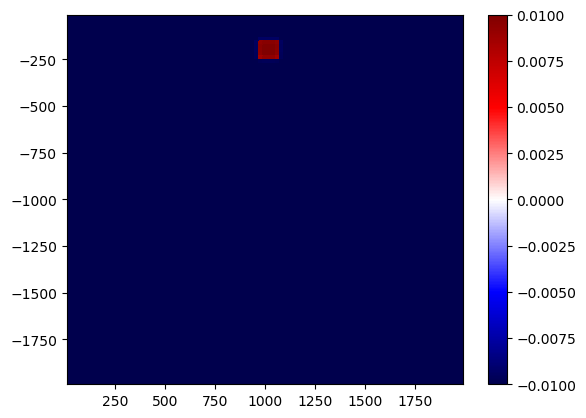

In [24]:
PyPlot.pcolormesh(xC, zC, rotr90(RT[end, :, 1, :]) .- 283, vmin=-0.01, vmax=0.01, cmap="seismic"); PyPlot.colorbar();

In [20]:
anim = @animate for tidx in 1:Int(Nᵗ/ΔR)
    Plots.heatmap(xC, zC, rotl90(RT[tidx, :, 1, :]) .- 283, color=:balance,
        clims=(-maximum(RT[tidx, :, 1, :] .- 283), maximum(RT[tidx, :, 1, :] .- 283)),
        title="T change @ t=$(tidx*ΔR*Δt)")
end
mp4(anim, "tracer.mp4", fps = 60)

┌ Info: Saved animation to 
│   fn = C:\Users\Ali\Documents\Git\Oceananigans.jl\tracer.mp4
└ @ Plots C:\Users\Ali\.julia\packages\Plots\y6yik\src\animation.jl:90


Plots.AnimatedGif("C:\\Users\\Ali\\Documents\\Git\\Oceananigans.jl\\tracer.mp4")

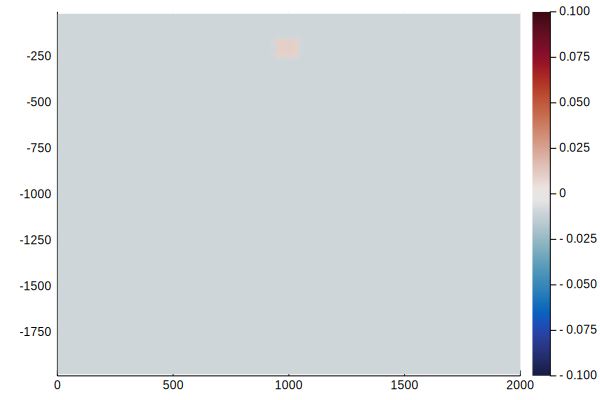

In [21]:
Plots.heatmap(xC, zC, rotl90(RT[end, :, 1, :]) .- 283, clims=(-0.1, 0.1), color=:balance)

In [22]:
matshow(RT[end, :, 1, :])

UndefVarError: UndefVarError: matshow not defined

In [25]:
sum(RT[10, :, 1, :] .- 282.99)

0.4999999999990905